### Single input Model - Model 2
In this file we build and train model 2 using the structure mentioned in the report. 

In [1]:
import os
from dotenv import dotenv_values
import numpy as np


import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator

from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [2]:
#get files from .env file
config = dotenv_values(".env")

In [3]:
# define repetitive values
raw_dir = config['RAW_PATH']

img_dim = int(config['DIM'])
batch_size = int(config['BATCH_SIZE'])
epoch_nbr = int(config['EPOCH'])

input_shape = (img_dim, img_dim, 3)

In [4]:
#in this code we are going to use the segmented dataset as the model's inut

#Paths to segmented data
seg_train_path = raw_dir + '/splitDataset/Segmented/train'
seg_val_path = raw_dir + '/splitDataset/Segmented/val'
seg_test_path = raw_dir + '/splitDataset/Segmented/test'

#### helper functions

In [5]:
# image data generator for train and val datasets
# data augmentation is applied only on the traing dataset

def image_data_generator():
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 20,
        horizontal_flip = True,
        shear_range=0.2, # shear the image
        zoom_range=0.2, # zoom into the image
        width_shift_range=0.2, # shift the image width ways
        height_shift_range=0.2, # shift the image height ways
    )
    
    validation_datagen = ImageDataGenerator(
        rescale = 1./255, 
    )
    
    test_datagen = ImageDataGenerator(
        rescale = 1./255, 
    )
    
    return [train_datagen, validation_datagen, test_datagen]

In [6]:
# Plot the validation and training data separately
def plot_loss_curves(history , metric , val_metric):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history[metric]
    val_accuracy = history.history[val_metric]

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [7]:
def evaluation_metrics(actual, predicted):
    class_names = ['Benign', 'Early', 'Pre', 'Pro']
    print(f"0 = {class_names[0]}, 1 = {class_names[1]}, 2 = {class_names[2]}, 3 = {class_names[3]}")
    print(classification_report(actual, predicted))
    plot_confusion_matrix(actual,
                          predicted,
                          title = "model 2 confusion matrix")

#### build the model

In [8]:
#create data generators
train_datagen, val_datagen, test_datagen = image_data_generator()

In [9]:
# Create segmented data batches
print("\nSegmented data set")
print("Augmented training images:")
seg_train_data = train_datagen.flow_from_directory(seg_train_path,
                                               target_size=(img_dim, img_dim),
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True) 

print("validation images:")
seg_val_data = val_datagen.flow_from_directory(seg_val_path,
                                             target_size=(img_dim, img_dim),
                                             batch_size=batch_size,
                                             class_mode='categorical')
print("test images:")
seg_test_data = test_datagen.flow_from_directory(seg_test_path,
                                             target_size=(img_dim, img_dim),
                                             batch_size=batch_size,
                                             class_mode='categorical')


Segmented data set
Augmented training images:
Found 2082 images belonging to 4 classes.
validation images:
Found 649 images belonging to 4 classes.
test images:
Found 525 images belonging to 4 classes.


In [10]:
# feature block

densenet_model = keras.applications.DenseNet201(include_top=False,
                                                weights="imagenet",
                                                input_tensor=None,
                                                input_shape=input_shape,
                                                pooling=None)

In [11]:
# with training case
# By setting the trainable property of this model we created to True,
# we allow the weights in trainable layers to be updated. 

densenet_model.trainable = True
count = 0
for layer in densenet_model.layers:
    if 'conv5' in layer.name:
        count = count + 1
        layer.trainable = True
    else:
        layer.trainable = False

print('nbr of trainable layers = ', count)

nbr of trainable layers =  224


In [12]:
input = keras.Input(shape=input_shape)

initializer = keras.initializers.he_normal(seed=32)

layer_1 = densenet_model(inputs=input)
layer_1 = keras.layers.Flatten()(layer_1)
#batch normailzation
layer_1 = keras.layers.BatchNormalization()(layer_1)
    
#Fully-connected block 1
layer_1 = keras.layers.Dense(units=16,
                             activation='relu',
                             kernel_initializer=initializer,
                             kernel_regularizer=keras.regularizers.l2(0.001)
                            )(layer_1)
layer_1 = keras.layers.BatchNormalization()(layer_1)
layer_1 = keras.layers.LeakyReLU()(layer_1)
layer_1 = keras.layers.Dropout(0.2)(layer_1)

#Fully-connected block 2
layer_1 = keras.layers.Dense(units=16,
                             activation='relu',
                             kernel_initializer=initializer,
                             kernel_regularizer=keras.regularizers.l2(0.001)
                            )(layer_1)

layer_1 = keras.layers.BatchNormalization()(layer_1)
layer_1 = keras.layers.ReLU()(layer_1)

#Classifier block
layer_1 = keras.layers.Dense(units=4,
                             kernel_initializer=initializer,
                             activation='softmax'
                            )(layer_1)


In [13]:
single_input_model_densenet201 = keras.models.Model(inputs=input, outputs=layer_1)
single_input_model_densenet201.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 94080)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 94080)             376320    
_________________________________________________________________
dense (Dense)                (None, 16)                1505296   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16)                0     

In [14]:
# compile model
single_input_model_densenet201.compile(loss='binary_crossentropy',
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])

In [15]:
model_history = single_input_model_densenet201.fit(seg_train_data,
                                       epochs=epoch_nbr,
                                       steps_per_epoch=len(seg_train_data),
                                       validation_data=seg_val_data,
                                       validation_steps=len(seg_val_data))

Epoch 1/100
66/66 [==============================] - 1000s 14s/step - loss: 0.5421 - accuracy: 0.7286 - val_loss: 0.3847 - val_accuracy: 0.6471
Epoch 2/100
66/66 [==============================] - 935s 14s/step - loss: 0.3711 - accuracy: 0.9179 - val_loss: 0.3172 - val_accuracy: 0.9337
Epoch 3/100
66/66 [==============================] - 933s 14s/step - loss: 0.2883 - accuracy: 0.9251 - val_loss: 0.2047 - val_accuracy: 0.9276
Epoch 4/100
66/66 [==============================] - 933s 14s/step - loss: 0.2211 - accuracy: 0.9486 - val_loss: 0.1515 - val_accuracy: 0.9676
Epoch 5/100
66/66 [==============================] - 935s 14s/step - loss: 0.1875 - accuracy: 0.9457 - val_loss: 0.1124 - val_accuracy: 0.9630
Epoch 6/100
66/66 [==============================] - 951s 14s/step - loss: 0.1570 - accuracy: 0.9568 - val_loss: 0.1295 - val_accuracy: 0.9522
Epoch 7/100
66/66 [==============================] - 933s 14s/step - loss: 0.1352 - accuracy: 0.9606 - val_loss: 0.1459 - val_accuracy: 0.933

66/66 [==============================] - 575s 9s/step - loss: 0.0571 - accuracy: 0.9846 - val_loss: 0.0858 - val_accuracy: 0.9661
Epoch 59/100
66/66 [==============================] - 546s 8s/step - loss: 0.0550 - accuracy: 0.9851 - val_loss: 0.0654 - val_accuracy: 0.9738
Epoch 60/100
66/66 [==============================] - 576s 9s/step - loss: 0.0602 - accuracy: 0.9813 - val_loss: 0.0721 - val_accuracy: 0.9661
Epoch 61/100
66/66 [==============================] - 522s 8s/step - loss: 0.0611 - accuracy: 0.9827 - val_loss: 0.0654 - val_accuracy: 0.9800
Epoch 62/100
66/66 [==============================] - 564s 9s/step - loss: 0.0571 - accuracy: 0.9837 - val_loss: 0.0662 - val_accuracy: 0.9753
Epoch 63/100
66/66 [==============================] - 609s 9s/step - loss: 0.0519 - accuracy: 0.9866 - val_loss: 0.0716 - val_accuracy: 0.9723
Epoch 64/100
66/66 [==============================] - 539s 8s/step - loss: 0.0638 - accuracy: 0.9784 - val_loss: 0.0723 - val_accuracy: 0.9738
Epoch 65/100

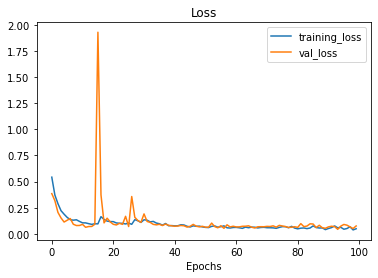

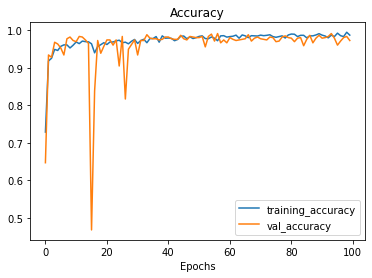

In [16]:
plot_loss_curves(model_history , 'accuracy' , 'val_accuracy')

### Evaluation of model 2

In [17]:
pred = single_input_model_densenet201.predict(seg_test_data)

In [18]:
correct_labels = seg_test_data.labels
predicted_labels = np.argmax(pred,axis = 1)

0 = Benign, 1 = Early, 2 = Pre, 3 = Pro
              precision    recall  f1-score   support

           0       0.23      0.21      0.22        82
           1       0.30      0.31      0.30       158
           2       0.30      0.30      0.30       155
           3       0.28      0.28      0.28       130

    accuracy                           0.28       525
   macro avg       0.28      0.27      0.28       525
weighted avg       0.28      0.28      0.28       525



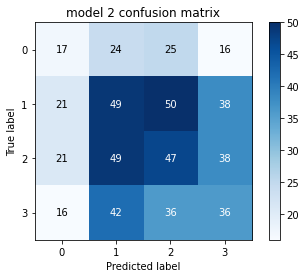

In [19]:
#view results
evaluation_metrics(correct_labels, predicted_labels)

In [20]:
# # Save a model
single_input_model_densenet201.save("saved_model/single_input_model.h5")